### **II) Training a convnet on a small database Julie Chapdelaine et Cleo Daguin**

In [0]:
import numpy as np
import pandas as pd
import keras
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import os

Préparation des données


*   Séparation des données de test et de training à la main dans 2 fichiers différents sur la machine.
*   Récupération des images
*   Redimensionnement des images en 80*80 pour uniformisation des données d'entréedu réseau
*   Transformation des images en nuance de gris car moins de calculs et couleurs pas forcément utiles pour distnguer un chat d'un chien
*   Passage des sorties de string a binaire avec chien == 1 et chat ==0



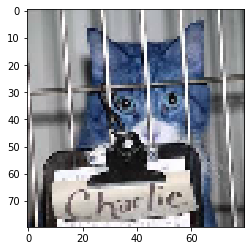

In [0]:
train_dir= "../ChatsChiens"
main_dir= "../CatsDogs"
path = os.path.join(main_dir, train_dir)

for p in os.listdir(path):
    category = p.split(".")[0]
    img_array = cv2.imread(os.path.join(path,p))
    new_img_array = cv2.resize(img_array, dsize=(80, 80))
    plt.imshow(new_img_array,cmap="gray")
    break

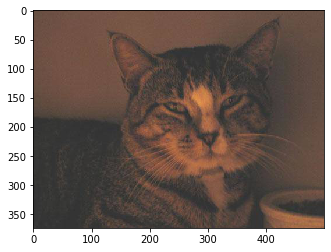

In [0]:
image = load_img("../CatsDogs/cat.751.jpg")
plt.imshow(image)

In [0]:
X = []
y = []
convert = lambda category : int(category == 'dog')
def create_test_data(path):
    for p in os.listdir(path):
        category = p.split(".")[0]
        category = convert(category)
        img_array = cv2.imread(os.path.join(path,p))
        new_img_array = cv2.resize(img_array, dsize=(128, 128))
        X.append(new_img_array)
        y.append(category)

In [0]:
create_test_data(path)
filenames = os.listdir(train_dir)
df = pd.DataFrame({
    'filename' : filenames,
    'category': y
})
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
df.head()

,filename,category
0,cat.587.jpg,cat
1,cat.692.jpg,cat
2,cat.501.jpg,cat
3,cat.273.jpg,cat
4,dog.716.jpg,dog


In [0]:
y = np.array(y)

Augmentation du nombre d'entrées en ajoutant des images d'origine avec une légère modification comme une rotation, un zoom, une déformation, etc ...

In [0]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
batch_size= 32
img_size=(128,128)

X_etendu = train_datagen.flow_from_dataframe(
    train_df, 
    "../ChatsChiens", 
    x_col='filename',
    y_col='category',
    target_size=img_size,
    class_mode='categorical',
    batch_size=batch_size
)

Found 1201 validated image filenames belonging to 2 classes.


**Création du model**


*   Mise en place d'une couche de convolutionsuivie d'un maxPooling et d'un dropout
*   Réitération de ces éléments avec motification des taillesd'entrée pour correspondre avec la taille de sortie de l'élément précédent.
*   Passage par un flatten pour ensuite avoir plusieurs couches denses et des dropout entre chaque.



In [0]:
model = Sequential()

model.add(Conv2D(32,(3,3), activation = 'relu', input_shape = (128,128,3)))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256,(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_31 (Dropout)         (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 28, 28, 128)      

Utilisation d'un callback qui dans ce cas va arrêter l'apprentissage lorsque la val-loss remonte trop. Cela permet de vérifier que notre model ne fais pas d'overfitting.

In [0]:
epochs = 20
batch_size = 32
callbacks = [
    EarlyStopping(patience=5, monitor='val_loss')
]
history = model.fit(X_etendu,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1)
print('Test score:', score)
print('Test accuracy:', acc)

Epoch 1/20
38/38 [==============================] - 28s 732ms/step - loss: 0.7429 - acc: 0.4938
Epoch 2/20
38/38 [==============================] - 26s 688ms/step - loss: 0.6938 - acc: 0.5229
Epoch 3/20
38/38 [==============================] - 25s 670ms/step - loss: 0.6935 - acc: 0.5137
Epoch 4/20
38/38 [==============================] - 29s 770ms/step - loss: 0.6934 - acc: 0.5096
Epoch 5/20
18/38 [=============>................] - ETA: 14s - loss: 0.6933 - acc: 0.4848

In [0]:
model.summary()